## Number of proteins in H. glaber and M. musculus proteomes
- Proteomes from Uniprot database

In [1]:
!grep '>' /media/savvy/DATA1/savvy/BLAST/model/het_glab/het_glab | wc -l

21445


In [2]:
!grep '>' /media/savvy/DATA1/savvy/BLAST/model/mus_musc/mus_musc | wc -l

22286


## Number of proteins in H. glaber and M. musculus ortholog proteomes

- Ortholog dataset obtained in April 2019 after running Inparanoid pipeline on H. glaber and M. musculus last version of Uniprot proteomes (Ortholog dataset from Inparanoid database was from 2013)

    - Simply run a perl script with MM and HG (proteome fasta file)
    - Ortholog table registered in `/media/savvy/DATA1/savvy/inparanoid/HG-MM_Uniprot/`
    - Run scripts in orthologSearch folder to generate ortholog proteome fasta file

### orthologSearch pipeline

#### Summary
This code helps to collect ortholog proteins for H. glaber and M. musculus found on Inparanoid database / from Inparanoid outputs.

##### STEP ONE: `run_get_orthologs.sh`
Set as paremeters :
- the ortholog proteome
- the sql table from Inparanoid database
You will collect fasta file for each organism with their respective ortholog proteins.

##### STEP TWO: `generate_ortholog_pairs.py`
This script will build a dataframe where will be provide for each ortholog cluster a pair of ortholog proteins.

##### STEP THREE (optionnal)
If you need a subset of ortholog proteins, you can use `ortholog_subsets.py` to create fasta files containing proteins selected with a specific condition (here a length range).


In [3]:
!grep '>' /home/savvy/Dropbox/Savvy/lifespan_difference/aggregation_difference/data/ortholog_dataset/uni_HG_cds_orthologs.faa | wc -l 

13806


In [4]:
!grep '>' /home/savvy/Dropbox/Savvy/lifespan_difference/aggregation_difference/data/ortholog_dataset/uni_MM_orthologs.faa | wc -l 

13806


## 1. Checking ortholog pairs quality

In [2]:
import os, progressbar, re

import numpy as np
import pandas as pd
import seaborn as sns
import tango_helpers as TH
import tmhmm_helpers as TM
import scipy.stats as stats
import matplotlib.pyplot as plt

from Bio import SeqIO

#### Ortholog fasta files

In [11]:
HG_fasta = '../../data/ortholog_dataset/uni_HG_orthologs.faa'
MM_fasta = '../../data/ortholog_dataset/uni_MM_orthologs.faa'

#### Ortholog dataframe

In [13]:
in_ortho_db = pd.read_csv('../../data/ortholog_dataset/HG_MM_Orthologs_Length.csv',sep='\t')
HG_ortho = in_ortho_db[['clusterNumber', 'proteinID_x', 'length_x']]
MM_ortho = in_ortho_db[['clusterNumber', 'proteinID_y', 'length_y']]

#### Pairwise alignment software
From: https://www.ebi.ac.uk/Tools/psa/

- __Stretcher__: EMBOSS Stretcher uses a modification of the Needleman-Wunsch algorithm that allows larger sequences to be globally aligned. 
- __Matcher__: EMBOSS Matcher identifies local similarities between two sequences using a rigorous algorithm based on the LALIGN application. 

In [14]:
#### Sequence handle functions

def check_annotations(ID, fastaFile):
    for seqRecord in SeqIO.parse(fastaFile, format='fasta'):
        if ID in seqRecord.id :
            if '_MOUSE' in seqRecord.description:
                description = re.findall(r'_MOUSE (.*) OS', seqRecord.description)[0]
            if '_HETGA' in seqRecord.description:
                description = re.findall(r'_HETGA (.*) OS', seqRecord.description)[0]
            return (ID, description) 
        
def return_seq(ID, fastaFile):
    for seqRecord in SeqIO.parse(fastaFile, format='fasta'):
        if ID in seqRecord.id :
            print(seqRecord.description)
            return str(seqRecord.seq)
        
def save_seq(ID, fastaFile, outFile):
    for seqRecord in SeqIO.parse(fastaFile, format='fasta'):
        if ID in seqRecord.id :
            SeqIO.write(seqRecord, open(outFile, 'w'), 'fasta')
            return outFile

In [15]:
#### Pairwise alignment software wrapper 

def align_metrics(needle_content, software):
    for line in needle_content :
        if "# 1" in line :
            proteinID_x = line.strip().split(' ')[2]
        if "# 2" in line :
            proteinID_y = line.strip().split(' ')[2]
        if 'Identity' in line:
            try:
                identity = re.findall(r'\(([0-9]*\.[0-9]+|[0-9]+)%\)', line.strip())[0]
            except:
                identity = re.findall(r'\( ([0-9]*\.[0-9]+|[0-9]+)%\)', line.strip())[0]
        if 'Similarity' in line:
            try:
                similarity = re.findall(r'\(([0-9]*\.[0-9]+|[0-9]+)%\)', line.strip())[0]
            except:
                similarity = rre.findall(r'\( ([0-9]*\.[0-9]+|[0-9]+)%\)', line.strip())[0]
        if 'Gaps' in line:
            try:
                gaps = re.findall(r'\(([0-9]*\.[0-9]+|[0-9]+)%\)', line.strip())[0]
            except:
                gaps = re.findall(r'\( ([0-9]*\.[0-9]+|[0-9]+)%\)', line.strip())[0]
            
    return proteinID_x, proteinID_y, identity, similarity, gaps, software
    
def return_align_scores(idx, software):
    HG_seq = save_seq(in_ortho_db['proteinID_x'][idx], HG_fasta,'./tmp/HG_tmp.fasta')
    MM_seq = save_seq(in_ortho_db['proteinID_y'][idx], MM_fasta,'./tmp/MM_tmp.fasta')
    os.system('{} {} {} -outfile {}'.format(software, HG_seq, MM_seq, './tmp/res_tmp.txt'))
    
    f = open('./tmp/res_tmp.txt', mode='r')
    stretcher = [ x for x in f.readlines() if '#' in x]
    f.close()
    return align_metrics(stretcher, software)

In [ ]:
#### Generating Global alignment
stretcher_scores = []
bar = progressbar.ProgressBar()

for idx in bar(in_ortho_db.index):
    stretcher_scores.append(return_align_scores(idx, 'matcher'))

#### Global alignment
stretcher_table = pd.DataFrame(stretcher_scores, columns=['proteinID_x', 'proteinID_y', '%_identity', '%_similarity', '%_gaps', 'software'])
stretcher_table['%_identity'] = stretcher_table['%_identity'].apply(float)
stretcher_table['%_similarity'] = stretcher_table['%_similarity'].apply(float)
stretcher_table['%_gaps'] = stretcher_table['%_gaps'].apply(float)
stretcher_table.to_csv('../../data/alignment_quality/HGMM_stretcher_scores.csv', index=False)

In [ ]:
#### Generating Local alignment
matcher_scores = []
bar = progressbar.ProgressBar()

for idx in bar(in_ortho_db.index):
    matcher_scores.append(return_align_scores(idx, 'matcher'))

#### Local alignment
matcher_table = pd.DataFrame(matcher_scores, columns=['proteinID_x', 'proteinID_y', '%_identity', '%_similarity', '%_gaps', 'software'])
matcher_table['%_identity'] = matcher_table['%_identity'].apply(float)
matcher_table['%_similarity'] = matcher_table['%_similarity'].apply(float)
matcher_table['%_gaps'] = matcher_table['%_gaps'].apply(float)
matcher_table.to_csv('../../data/alignment_quality/HGMM_matcher_scores.csv', index=False)

In [16]:
stretcher_table = pd.read_csv('../../data/alignment_quality/HGMM_stretcher_scores.csv')
matcher_table = pd.read_csv('../../data/alignment_quality/HGMM_matcher_scores.csv')

stretcher_table = stretcher_table.merge(in_ortho_db, on=['proteinID_x', 'proteinID_y'])
stretcher_table['diff_length'] = stretcher_table['length_x'] - stretcher_table['length_y']
stretcher_table['diff_length_z-scores'] = stats.zscore(stretcher_table['diff_length'])

matcher_table = matcher_table.merge(in_ortho_db, on=['proteinID_x', 'proteinID_y'])
matcher_table['diff_length'] = matcher_table['length_x'] - matcher_table['length_y']
matcher_table['diff_length_z-scores'] = stats.zscore(matcher_table['diff_length'])

<Figure size 432x288 with 0 Axes>

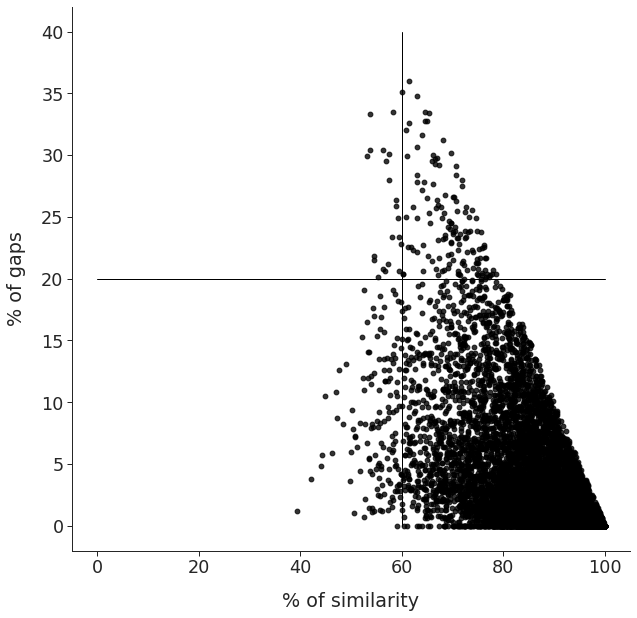

% of similarity average:  88.69177893669419


In [17]:
sns.set_context("paper", font_scale=2)
sns.set_style("ticks") 
sns.despine(offset=10)

fig = plt.figure(figsize=(10, 10))

sns.regplot(x=matcher_table['%_similarity'], y=matcher_table['%_gaps'], fit_reg=False, color='black')
plt.plot([60, 60], [40, 0], linewidth=1, color='black') ## threshold 60%
plt.plot([100, 0], [20, 20], linewidth=1, color='black') ## threshold 20%
plt.xlabel('% of similarity', labelpad=15)
plt.ylabel('% of gaps', labelpad=15)
# plt.title('Local alignment metrics for mouse and naked mole rat ortholog pairs')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(top=False, bottom=True, left=True, right=False, labelleft=True, labelbottom=True)   
plt.show()

print('% of similarity average: ', matcher_table['%_similarity'].mean())

plt.show()

### Exclude ortholog pairs with poor quality

In [18]:
bad_orthologs = matcher_table[(matcher_table['%_similarity'] < 60) & (matcher_table['%_gaps'] > 20)]
print(f'Number of ortholog pairs with low metrics: {len(bad_orthologs)}')

Number of ortholog pairs with low metrics: 21


In [19]:
bad_orthologs = matcher_table[(matcher_table['%_similarity'] < 60) | (matcher_table['%_gaps'] > 20)]
print(f'Number of ortholog pairs with low metrics: {len(bad_orthologs)}')

Number of ortholog pairs with low metrics: 293


In [20]:
all_validated_orthologs = matcher_table[~matcher_table['proteinID_y'].isin(bad_orthologs['proteinID_y'])]
print(len(all_validated_orthologs))

13513


#### Checking alignments of the bad orthologs
- Original code for displaying alignement found here: https://dmnfarrell.github.io/bioinformatics/bokeh-sequence-aligner
- Original author: Damien Farrell (2019)

In [21]:
import os, io, random
import string
import numpy as np

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot

def get_colors(seqs):
    """make colors for bases in sequence"""
    text = [i for s in list(seqs) for i in s]
    #### Color code from Clustal colour scheme
    clrs =  {'A':'blue',
             'I':'blue',
             'L':'blue',
             'M':'blue',
             'F':'blue',
             'W':'blue',
             'V':'blue',
             'C':'blue',
             'K':'red',
             'R':'red',
             'E':'magenta',
             'D':'magenta',
             'N':'green',
             'Q':'green',
             'S':'green',
             'T':'green',
             'C':'pink',
             'G':'orange',
             'P':'yellow',
             'H':'cyan',
             'Y':'cyan',
             '-':'white'
            }
    colors = [clrs[i] for i in text]
    return colors

def view_alignment(aln, fontsize="9pt", plot_width=800):
    """Bokeh sequence alignment view"""

    #make sequence and id lists from the aln object
    seqs = [rec.seq for rec in (aln)]
    ids = [rec.id for rec in aln]    
    text = [i for s in list(seqs) for i in s]
    colors = get_colors(seqs)    
    N = len(seqs[0])
    S = len(seqs)    
    width = .4

    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    x_range = Range1d(0,N+1, bounds='auto')
    if N>100:
        viewlen=100
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0,viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #entire sequence view (no text, with zoom)
    p = figure(title=None, plot_width= plot_width, plot_height=50,
               x_range=x_range, y_range=(0,S), tools=tools,
               min_border=0, toolbar_location='below')
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                 line_color=None, fill_alpha=0.6)
    p.add_glyph(source, rects)
    p.yaxis.visible = False
    p.grid.visible = False  

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=view_range, y_range=ids, tools="xpan,reset",
                min_border=0, toolbar_location='below')#, lod_factor=1)          
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",
                text_font="monospace",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = False
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p],[p1]], toolbar_location='below')
    return p

#### Generation of protein alignments 
-  Use the script `build_alignment.py`

In [23]:
bad_path = '../../data/alignment_quality/bad/'
bad = [ aln for aln in os.listdir(bad_path) ]

In [24]:
def get_aln_stats(ID, val_type):
    if val_type == 'similarity' :
        return matcher_table[matcher_table['proteinID_y'] == ID ]['%_similarity'].values[0]
    if val_type == 'gaps' :
        return matcher_table[matcher_table['proteinID_y'] == ID ]['%_gaps'].values[0]

In [26]:
i = 5

MM = bad[i].strip('.fasta').split('_')[0]
HG = bad[i].strip('.fasta').split('_')[1]
MM, MM_gene = check_annotations(MM, MM_fasta)
HG, HG_gene = check_annotations(HG, HG_fasta)
print(MM, MM_gene,'\n', HG, HG_gene,'\n')

print('Metrics from matcher software')
print('% of similarity:', get_aln_stats(MM, 'similarity'))
print('% of gaps:', get_aln_stats(MM, 'gaps'))
aln = AlignIO.read(f'{bad_path}{bad[i]}','fasta')
p = view_alignment(aln, plot_width=900)
pn.pane.Bokeh(p)


Q9R0L9 Sialomucin core protein 24 
 G5BEM2 Sialomucin core protein 24 

Metrics from matcher software
% of similarity: 58.0
% of gaps: 23.4


Bokeh(Column)

## 2. Removing proteins known as transmembrane proteins based on gene annotations

In [27]:
def is_transmembrane(description):
    if ('Transmembrane' in description) or ('transmembrane' in description):
        return True
    else: 
        return False

def collect_transmembrane_proteins(model_fasta):    
    anno_transmembrane = []
    bar = progressbar.ProgressBar()
    for seqRecord in SeqIO.parse(model_fasta, format='fasta'):
            trans_bool = is_transmembrane(seqRecord.description)
            if trans_bool :
                anno_transmembrane.append(seqRecord.id)
    return anno_transmembrane

In [28]:
MM_anno_transmembrane = collect_transmembrane_proteins(MM_fasta)

In [29]:
len(MM_anno_transmembrane)

278

## 3. Running TMHMM to exclude transmembrane proteins
- The TMHMM outputs were generated after running:
    - `cat /home/savvy/Dropbox/Savvy/Code/orthologSearch/uniprot_results/uni_HG_orthologs.faa | tmhmm > HG_TMHMM_results.txt`
    - `cat /home/savvy/Dropbox/Savvy/Code/orthologSearch/uniprot_results/uni_MM_orthologs.faa | tmhmm > MM_TMHMM_results.txt`
    
- The output file is composed of :
    - Line with __#__ containing a specific value
    - Line without __#__ giving the location of transmembrane domains
- For each protein, the following lines have to identify the for each #\_line the type value in order to store with its attributed key of the storage dictionnary. 

In [30]:
MM_TMHMM = TM.collect_TMHMM_results('../../data/TMHMM/MM_TMHMM_results.txt')
TM_protein = MM_TMHMM[MM_TMHMM['TM_protein'] == True]['proteinID']
print(f'Number of proteins with transmembrane regions: {len(TM_protein)}')

Number of proteins with transmembrane regions: 3649


In [31]:
len(set(MM_anno_transmembrane) | set(TM_protein))

3664

## 4. Collect chaperone client proteins

In [34]:
#### homo_sapiens chaperone client proteins
h_sapiens_chap_clt = pd.read_csv('../../data/chaperone_clients/10142_2020_740_MOESM2_ESM-1.csv')

In [35]:
len(h_sapiens_chap_clt[h_sapiens_chap_clt['Chaperone_client'] != 'Non-client']['H.sapiens'])

1956

- Ensembl --> Uniprot IDs mapping performed with Uniprot

In [3]:
uniprot_mapping = pd.read_csv('../../data/chaperone_clients/human_ensembl_to_uniprot.tab', sep='\t')
hs_mm_orthologs = pd.read_csv('../../data/chaperone_clients/HS_MM_uni_ortholog_groups.csv', sep='\t')
hs_mm_orthologs = hs_mm_orthologs[['proteinID_x', 'proteinID_y']]
mm_chap_clt = hs_mm_orthologs[hs_mm_orthologs['proteinID_x'].isin(uniprot_mapping['Entry'])]['proteinID_y']

In [4]:
len(mm_chap_clt)

1885

## 5. Collect Tango scores

### a. Run Tango for each sequence in H. glaber and M. musculus proteome
- Before running Tango, replace potential U amino acids to X with `format_proteins.py`
- For running Tango, need to create an SEQ file input

```
### Example
G5B3P4 N N 7 298 0.1 MDIKSGKELLLIGNVPISAADELSDAVMKEKESQGAVPELKEEKSQPQAKPHSGVVKETFRIVNDTLNDDIVKATQVIYQFELSDEDRGTWFLDLKSKGGNVGHGEQSNHADVVMSMSTDDLVKMFSGKLKPTMAFMSGKLKIKRNTALAIKLEKLMNQMHCRL
```

- Once the SEQ files are created, run this command line in the SEQ folder:
- `for SEQFILE in *.seq ; do /home/savvy/bin/tango -inputfile=$SEQFILE ; done`

In [41]:
%%time
orth_HG = TH.collectSeq(HG_fasta)
orth_MM = TH.collectSeq(MM_fasta)

CPU times: user 263 ms, sys: 16.4 ms, total: 280 ms
Wall time: 278 ms


In [ ]:
## Crate SEQ files for HG and MM
for seq in orth_HG:
    TH.createSEQ('/media/savvy/DATA3/savvy/project_2018/WT_TANGO/HG/', seq)
for seq in orth_MM:
    TH.createSEQ('/media/savvy/DATA3/savvy/project_2018/WT_TANGO/MM/', seq)

### b. Collect WT Tango scores for H. glaber and M. musculus
- Calculation of % of Aggregation :

$$ \begin{equation} Normalized\_aggregation\_score = \frac{\sum Aggregation\_propensity\_score_{AA}}{Number\_of\_AA\_in\_the\_protein\_sequence} \end{equation}$$


In [42]:
%%time
bar = progressbar.ProgressBar()
tango_output = '/media/savvy/DATA3/savvy/project_2018/WT_TANGO/HG/'
HG_tangoScore = []
for tangoTable in bar(os.listdir(os.path.join(tango_output))):
    if ('.txt' in tangoTable) and ('_aggregation' not in tangoTable):
        HG_tangoScore.append(TH.collect_aggScore(os.path.join(tango_output, tangoTable)))

100% (40870 of 40870) |##################| Elapsed Time: 0:01:58 Time:  0:01:58


CPU times: user 42.5 s, sys: 1.78 s, total: 44.2 s
Wall time: 1min 59s


In [43]:
%%time
bar = progressbar.ProgressBar()
tango_output = '/media/savvy/DATA3/savvy/project_2018/WT_TANGO/MM/'
MM_tangoScore = []
for tangoTable in bar(os.listdir(os.path.join(tango_output))):
    if ('.txt' in tangoTable) and ('_aggregation' not in tangoTable):
        MM_tangoScore.append(TH.collect_aggScore(os.path.join(tango_output, tangoTable)))

100% (41396 of 41396) |##################| Elapsed Time: 0:02:03 Time:  0:02:03


CPU times: user 44.1 s, sys: 1.77 s, total: 45.8 s
Wall time: 2min 4s


In [44]:
print('Total number of Tango scores computed for HG:', len(HG_tangoScore))
print('Total number of Tango scores computed for MM:', len(MM_tangoScore))

Total number of Tango scores computed for HG: 13258
Total number of Tango scores computed for MM: 13784


In [45]:
HG_agg = pd.DataFrame(HG_tangoScore, columns=['proteinID_x', 'Aggregation_x'])
MM_agg = pd.DataFrame(MM_tangoScore, columns=['proteinID_y', 'Aggregation_y'])

In [46]:
HG_agg = HG_agg.merge(HG_ortho, on='proteinID_x')
MM_agg = MM_agg.merge(MM_ortho, on='proteinID_y')

#### Dataframe with all Tango scores

In [47]:
#### Add gene name information
gene_dict = {}
for seqRecord in SeqIO.parse(MM_fasta, format='fasta'):
    description = seqRecord.description
    pattern = "GN=(.*?) PE="
    try:
        substring = re.search(pattern, description).group(1)
        gene_dict[seqRecord.id] = substring
    except: 
        gene_dict[seqRecord.id] = ''

def set_gene_name(x):
    return gene_dict[x]

In [48]:
ortho_pairs = HG_agg.merge(MM_agg, on='clusterNumber')
ortho_pairs['diff_length'] = ortho_pairs['length_x'] - ortho_pairs['length_y']
ortho_pairs['gene_name'] = ortho_pairs['proteinID_y'].apply(set_gene_name)

print(f'Number of Tango scores computed for HG and MM orthologs: {len(ortho_pairs)}')

Number of Tango scores computed for HG and MM orthologs: 13237


## 6. Collect PASTA scores

### a. Run PASTA for each sequence in H. glaber and M. musculus proteome
- Command line 

In [49]:
def collect_pasta_aggScore(ID, model):
    if 'MM' in model :
        tango_output = '/media/savvy/DATA3/savvy/project_2018/WT_PASTA/MM/'
    if 'HG' in model :
        tango_output = '/media/savvy/DATA3/savvy/project_2018/WT_PASTA/HG/'
    table = pd.read_csv(f'{tango_output}{ID}.aggr_profile.dat', names=['Pasta_Aggregation'], sep='\t')
    return sum(table['Pasta_Aggregation']*100)/len(table)

In [50]:
%%time
ortho_pairs['Pasta_Aggregation_x']= ortho_pairs['proteinID_x'].apply(collect_pasta_aggScore, args=('HG',))
ortho_pairs['Pasta_Aggregation_y']= ortho_pairs['proteinID_y'].apply(collect_pasta_aggScore, args=('MM',))

## 7. Selecting Tango scores for the final ortholog subset
- Removing transmembrane proteins

In [51]:
ALL_TM = set(MM_anno_transmembrane) | set(TM_protein)

In [52]:
TO_REMOVE = ortho_pairs[(ortho_pairs['proteinID_y'].isin(ALL_TM)) | (ortho_pairs['proteinID_y'].isin(bad_orthologs['proteinID_y'])) ] 

In [53]:
len(TO_REMOVE)

3715

In [54]:
FINAL_SUBSET = ortho_pairs[~ortho_pairs['proteinID_y'].isin(TO_REMOVE['proteinID_y'])]

In [55]:
len(FINAL_SUBSET)

9522

In [56]:
FINAL_SUBSET.to_csv('../../data/aggregation_propensity/HGMM_agg_scores.csv', sep=',', index=False)

<Figure size 432x288 with 0 Axes>

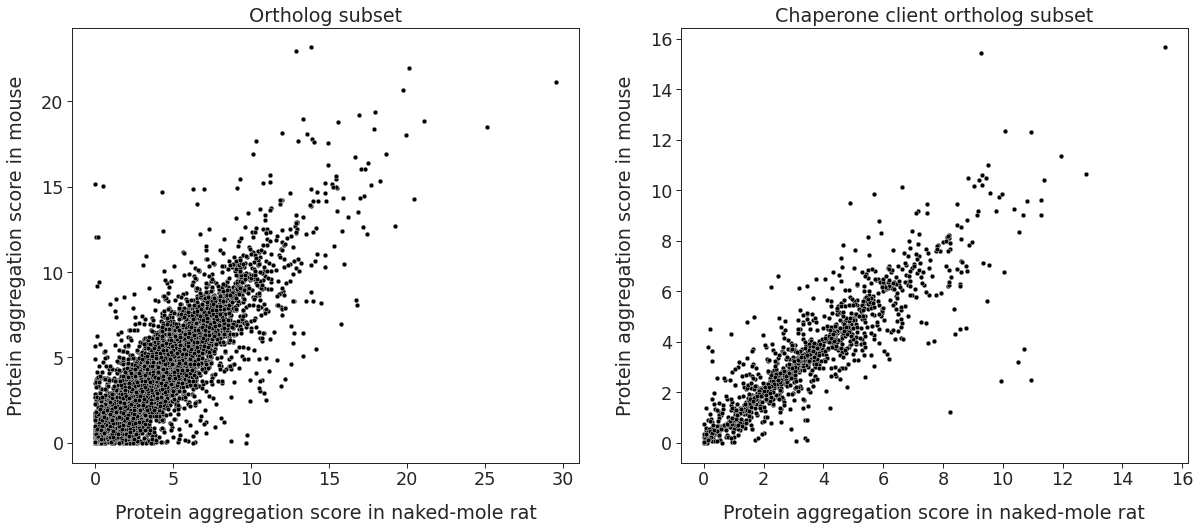

correlation score:0.889748617743069, pvalue:0.0
correlation score:0.8938464835980767, pvalue:0.0


In [57]:
sns.set_context("paper", font_scale=2)
sns.set_style("ticks") 
sns.despine(offset=20)

fig,axes = plt.subplots(nrows=1, ncols=2, figsize= (20, 8))

FINAL_SUBSET = ortho_pairs[~ortho_pairs['proteinID_y'].isin(TO_REMOVE['proteinID_y'])]
sns.scatterplot(x=FINAL_SUBSET['Aggregation_x'], y=FINAL_SUBSET['Aggregation_y'], color='black', ax=axes[0])
axes[0].set_title('Ortholog subset')
axes[0].set_xlabel('Protein aggregation score in naked-mole rat', labelpad=15)
axes[0].set_ylabel('Protein aggregation score in mouse', labelpad=15)

CHAP_CLT = FINAL_SUBSET[FINAL_SUBSET['proteinID_y'].isin(mm_chap_clt)]
CHAP_SUBSET = CHAP_CLT[(CHAP_CLT['Aggregation_x'] != 0) | (CHAP_CLT['Aggregation_y'] != 0)]
sns.scatterplot(x=CHAP_SUBSET['Aggregation_x'], y=CHAP_SUBSET['Aggregation_y'], color='black', ax=axes[1])
axes[1].set_title('Chaperone client ortholog subset')
axes[1].set_xlabel('Protein aggregation score in naked-mole rat', labelpad=15)
axes[1].set_ylabel('Protein aggregation score in mouse', labelpad=15)
 
plt.show()

# Correlation between HG and MM Tango scores
corr, pval = stats.pearsonr(FINAL_SUBSET['Aggregation_x'], FINAL_SUBSET['Aggregation_y'])
print(f'correlation score:{corr}, pvalue:{pval}')

corr, pval = stats.pearsonr(CHAP_SUBSET['Aggregation_x'], CHAP_SUBSET['Aggregation_y'])
print(f'correlation score:{corr}, pvalue:{pval}')


#### General statistic on the dataset

In [58]:
#### ALL
matcher_table[matcher_table['proteinID_y'].isin(ortho_pairs['proteinID_y'])].describe()

%_identity  %_similarity        %_gaps  clusterNumber      length_x  \
count  13237.000000  13237.000000  13237.000000   13237.000000  13237.000000   
mean      83.191901     88.847125      2.477842    7240.088389    587.898466   
std       12.269468      9.285436      4.328584    4250.297732    516.491153   
min       25.200000     39.300000      0.000000       2.000000     44.000000   
25%       76.500000     84.300000      0.000000    3568.000000    288.000000   
50%       85.600000     91.100000      0.600000    7122.000000    448.000000   
75%       92.700000     96.000000      2.900000   10886.000000    717.000000   
max      100.000000    100.000000     36.000000   14898.000000  10159.000000   

           length_y   diff_length  diff_length_z-scores  
count  13237.000000  13237.000000          13237.000000  
mean     604.822845    -16.924379             -0.002693  
std      533.526954    116.992239              0.954632  
min       44.000000  -2152.000000            -17.424464  
25%      299.000000    -28.000000             -0.093068  
50%      460.000000      0.000000              0.135406  
75%      734.000000      4.000000              0.168045  
max     8891.000000   1303.000000             10.767614

In [59]:
#### TRANSMEMBRANE PROTEINS
matcher_table[(matcher_table['proteinID_y'].isin(ortho_pairs['proteinID_y'])) & (~matcher_table['proteinID_y'].isin(bad_orthologs['proteinID_y'])) & (matcher_table['proteinID_y'].isin(ALL_TM))].describe()

%_identity  %_similarity       %_gaps  clusterNumber     length_x  \
count  3440.000000   3440.000000  3440.000000    3440.000000  3440.000000   
mean     83.248459     89.281163     1.809971    7585.800000   542.800000   
std      11.415409      8.292177     3.264982    4141.156814   491.917266   
min      37.200000     60.000000     0.000000       2.000000    47.000000   
25%      77.100000     84.900000     0.000000    4125.000000   285.000000   
50%      85.500000     91.400000     0.400000    7732.000000   412.000000   
75%      92.100000     95.600000     1.900000   10970.000000   649.250000   
max     100.000000    100.000000    20.000000   14878.000000  8825.000000   

          length_y  diff_length  diff_length_z-scores  
count  3440.000000  3440.000000           3440.000000  
mean    560.552616   -17.752616             -0.009452  
std     513.932169    99.826990              0.814567  
min      47.000000 -2132.000000            -17.261269  
25%     297.000000   -26.000000             -0.076748  
50%     423.000000     0.000000              0.135406  
75%     674.250000     3.000000              0.159885  
max    8799.000000   577.000000              4.843606

In [60]:
#### GLOBULAR PROTEINS
matcher_table[ (matcher_table['proteinID_y'].isin(ortho_pairs['proteinID_y'])) & (~matcher_table['proteinID_y'].isin(bad_orthologs['proteinID_y'])) & (~matcher_table['proteinID_y'].isin(ALL_TM))].describe()

%_identity  %_similarity       %_gaps  clusterNumber      length_x  \
count  9522.000000   9522.000000  9522.000000    9522.000000   9522.000000   
mean     84.030361     89.470111     2.303203    7028.425646    603.674648   
std      11.461570      8.460217     3.670118    4248.556389    523.628515   
min      40.100000     60.000000     0.000000       3.000000     44.000000   
25%      77.300000     84.800000     0.000000    3348.750000    289.000000   
50%      86.100000     91.400000     0.600000    6762.500000    462.000000   
75%      93.200000     96.200000     2.900000   10726.000000    735.000000   
max     100.000000    100.000000    20.000000   14892.000000  10159.000000   

          length_y  diff_length  diff_length_z-scores  
count  9522.000000  9522.000000           9522.000000  
mean    619.097984   -15.423335              0.009555  
std     535.563368   114.505399              0.934340  
min      44.000000 -2150.000000            -17.408145  
25%     300.000000   -27.000000             -0.084908  
50%     474.000000     0.000000              0.135406  
75%     756.000000     5.000000              0.176205  
max    8891.000000  1303.000000             10.767614

In [61]:
#### Chaperone protein clients
matcher_table[ (matcher_table['proteinID_y'].isin(ortho_pairs['proteinID_y'])) & (~matcher_table['proteinID_y'].isin(ALL_TM)) & (matcher_table['proteinID_y'].isin(mm_chap_clt)) ].describe()

%_identity  %_similarity       %_gaps  clusterNumber     length_x  \
count  1318.000000   1318.000000  1318.000000    1318.000000  1318.000000   
mean     86.855463     91.255159     2.521472    6224.913505   630.992413   
std      10.352886      7.923184     4.481854    3842.578456   515.414813   
min      39.400000     52.600000     0.000000       3.000000    44.000000   
25%      81.400000     87.400000     0.000000    2981.250000   338.250000   
50%      89.100000     93.500000     0.500000    5904.000000   499.000000   
75%      94.800000     97.200000     2.875000    9040.750000   757.000000   
max     100.000000    100.000000    33.500000   14845.000000  5393.000000   

          length_y  diff_length  diff_length_z-scores  
count  1318.000000  1318.000000           1318.000000  
mean    647.503035   -16.510622              0.000683  
std     520.971279   110.513200              0.901765  
min      44.000000 -1616.000000            -13.050816  
25%     350.000000   -29.000000             -0.101228  
50%     508.500000     0.000000              0.135406  
75%     767.250000     4.000000              0.168045  
max    5180.000000   702.000000              5.863579

In [62]:
#### Excluded orthologs
matcher_table[ (matcher_table['proteinID_y'].isin(ortho_pairs['proteinID_y'])) & (matcher_table['proteinID_y'].isin(bad_orthologs['proteinID_y'])) ].describe()

%_identity  %_similarity      %_gaps  clusterNumber     length_x  \
count  275.000000    275.000000  275.000000     275.000000   275.000000   
mean    53.452364     61.846545   16.879273   10244.469091   605.781818   
std     12.632790      8.202956    9.404183    4253.165009   535.973379   
min     25.200000     39.300000    0.000000      56.000000    53.000000   
25%     44.150000     55.800000    8.000000    7098.500000   243.000000   
50%     50.700000     59.300000   20.400000   11477.000000   466.000000   
75%     64.600000     69.300000   23.800000   13955.500000   766.500000   
max     78.100000     78.500000   36.000000   14898.000000  3754.000000   

          length_y  diff_length  diff_length_z-scores  
count   275.000000   275.000000            275.000000  
mean    664.320000   -58.538182             -0.342253  
std     658.366209   280.497241              2.288799  
min      90.000000 -2152.000000            -17.424464  
25%     286.000000  -125.500000             -0.888648  
50%     473.000000   -32.000000             -0.125707  
75%     770.000000    46.500000              0.514836  
max    4998.000000   654.000000              5.471909